# 1. Environment configuration

In [1]:
import sys
sys.path.append('../')

import os, cv2, glob, shutil, re, time

import numpy as np
import tensorflow as tf
from PIL import ImageFile
import matplotlib.pyplot as plt

from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot


from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.preprocessing.image import * 

from keras.models import Model, load_model
from keras import backend as K
from keras.utils import multi_gpu_model
from keras.applications.resnet50 import ResNet50
from keras.applications import inception_v3, inception_resnet_v2, xception

from keras.applications.xception import preprocess_input as preprocess_input_ception
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from keras.applications.densenet import preprocess_input as preprocess_input_densenet


from model.metric import any_accuracy, all_accuracy, R0, R1

from model.new_coremodel import model_mixed8_v7_sn_3 as my_model           # change to new model

from dataload.my_image_attr_cutout_11 import MyImageDataGenerator

print('Import modules done!')


ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ["CUDA_VISIBLE_DEVICES"] = " 0, 1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True  
sess = tf.Session(config=config) 


nb_gpus = 2
mbatch_size = 88
nb_epochs = 50

model_new_name = 'v3_mixed8_sn_dilation_v7'

basemodel_name = 'inception_v3'
model_image_size = (444, 592)
base_project = os.path.abspath('../')
model = my_model(basemodel_name=basemodel_name, model_image_size=model_image_size, column_num=1)
model.name = model_new_name
print('Model built...')

if basemodel_name == 'resnet50':
    preprocess_input = preprocess_input_resnet
elif basemodel_name == 'xception' or 'inception_v3' or 'inception_resnet_v2':
    preprocess_input = preprocess_input_ception
elif basemodel_name == 'densenet121' or 'densenet169' or 'densenet201':
    preprocess_input = preprocess_input_densenet
else:
    print('basemodel_name not defined！')
    raise NameError

/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Import modules done!
Model built...


# 2. Data preparation

In [3]:
# expand_basedir = os.path.join(base_project, 'dataspace/v3_ExpandedSet_85_with123/')
# original_basedir = os.path.join(base_project, 'dataspace/v3_OriginalSet_85_with123/')


task = 'task85'

original_basedir = os.path.join(base_project, 'dataspace/v3_symlinks_'+ task) 
expand_basedir = original_basedir

start_time = time.time()
train_gen = MyImageDataGenerator(preprocessing_function = preprocess_input,
    width_shift_range=.15, 
    height_shift_range=.15, 
    shear_range=1, 
    rotation_range=6,
    zoom_range=(0.95, 1.15), 
    channel_shift_range =30,
#     vertical_flip=False,
#     zca_whitening=True
    )

# train_gen.fit(x_train)

eval_gen  = MyImageDataGenerator(preprocessing_function = preprocess_input)


train_batch_size = mbatch_size
train_generator = train_gen.myflow_from_directory(
    my_horizontal_flip = True,
    my_cutout = True,
    directory=os.path.join(expand_basedir, 'train'),
    target_size = model_image_size, shuffle = True, class_mode='binary',  batch_size = train_batch_size)
if train_generator.samples % train_batch_size == 0:
    steps_train = train_generator.samples // train_batch_size
else:
    steps_train = train_generator.samples // train_batch_size + 1
print("steps_train = {}".format(steps_train))


test_batch_size = mbatch_size
test_generator = eval_gen.myflow_from_directory(
    directory = os.path.join(original_basedir, 'test'),
    target_size = model_image_size, shuffle = False,  class_mode = 'binary',  batch_size = test_batch_size)
if test_generator.samples % test_batch_size == 0:
    steps_test = test_generator.samples // test_batch_size
else:
    steps_test = test_generator.samples // test_batch_size + 1
print("steps_test = {}".format(steps_test))


valid_batch_size = mbatch_size
valid_generator = eval_gen.myflow_from_directory(
    directory = os.path.join(original_basedir, 'valid'),
    target_size = model_image_size, shuffle=False, class_mode='binary', batch_size=valid_batch_size)
if valid_generator.samples % valid_batch_size == 0:
    steps_valid = valid_generator.samples // valid_batch_size
else:
    steps_valid = valid_generator.samples // valid_batch_size + 1
print("steps_valid = {}".format(steps_valid))

print(train_generator.class_indices)
print('total time:{:.1f} minutes.'.format((time.time() - start_time)/60))

Found 1372 samples belonging to 2 classes.
steps_train = 16
Found 343 samples belonging to 2 classes.
steps_test = 4
Found 0 samples belonging to 2 classes.
steps_valid = 0
{'0_normal': 0, '1_abnormal': 1}
total time:0.0 minutes.


# 3. Training process

In [4]:

model_path = os.path.join(base_project,  'checkpoints/' + model.name)

if not os.path.exists(model_path):
    os.makedirs(model_path)

class CustomModelCheckpoint(Callback):
    def __init__(self, model, path, init_loss=np.inf,init_acc=-1):
        self.mymodel = model
        self.path = path
        self.best_loss = init_loss
        self.best_acc = init_acc
        
    def on_epoch_end(self, epoch, logs=None):
        stamp = time.strftime('%Y%m%d%H%M',time.localtime(time.time()))
        
        val_loss = logs['val_x1_loss']
        val_acc = logs['val_x1_acc']
        model_name = '{}_{}_{:.4f}_{:.4f}{}'.format(model.name, stamp, val_loss, val_acc, '.h5')
        model_path = os.path.join(self.path, model_name)
        short_name = '{}.h5'.format(model.name)
        
        if val_loss < self.best_loss:
            print("\nValidation loss decreased from {:.4f} to {:.4f}, saving model to {}".format(self.best_loss, val_loss, model_name))
            self.mymodel.save_weights(model_path, overwrite=True)
            self.mymodel.save_weights(os.path.join(self.path, short_name), overwrite=True)
            self.best_loss = val_loss
            if val_acc > self.best_acc:
                self.best_acc = val_acc
        elif val_acc > self.best_acc:
            print("\nValidation acc increased from {:.4f} to {:.4f}, saving model to {}".format(self.best_acc, val_acc, model_name))
            self.mymodel.save_weights(model_path, overwrite=True)
            self.best_acc = val_acc
            if val_loss < self.best_loss:
                self.best_loss = val_loss

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 444, 592, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 221, 295, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 221, 295, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 221, 295, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

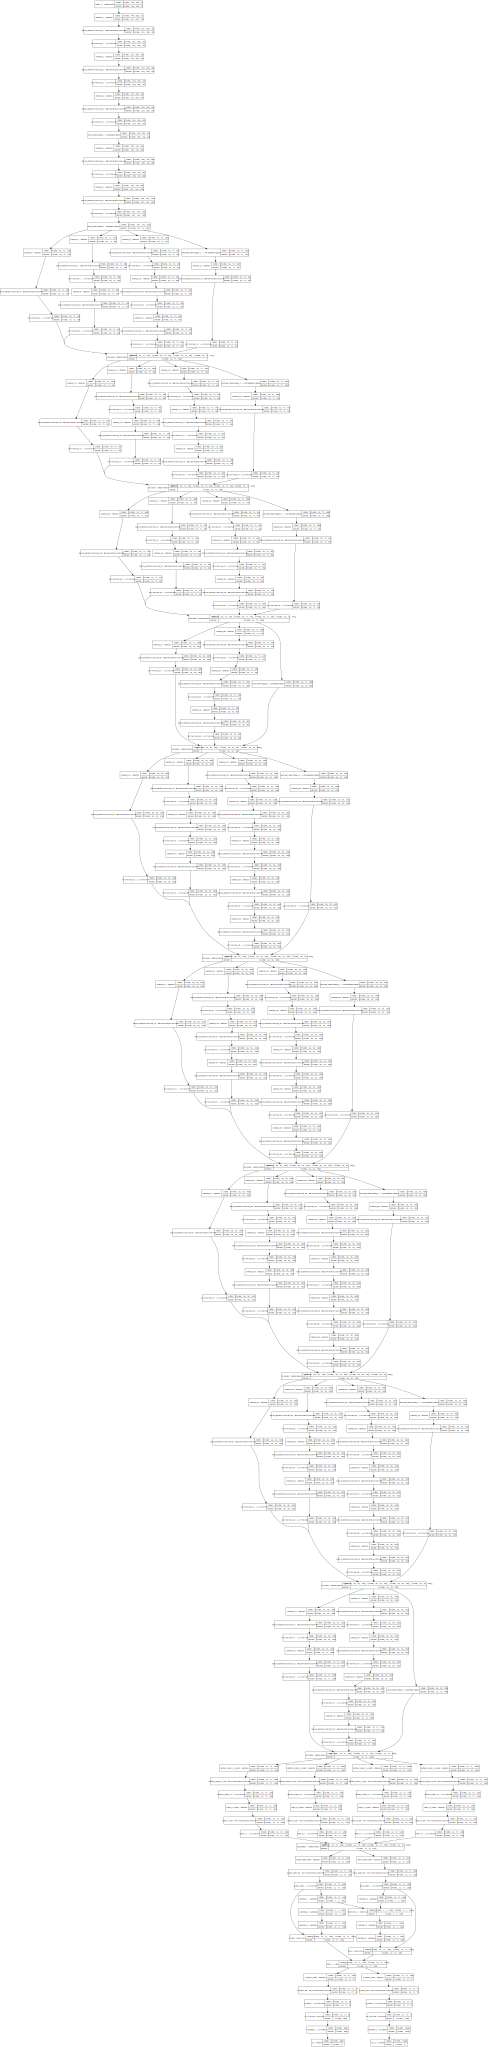

In [5]:

model.summary()

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 3.1  Learning rate = 1e-3

In [ ]:
model_h5 = 'v3_mixed8_sn_dilation_v7_201812052028_0.0812_0.9844.h5'
model.load_weights(os.path.join(model_path, model_h5))
check_point = CustomModelCheckpoint(model, model_path,init_loss=0.1, init_acc=0.97)
Earlystop = EarlyStopping(monitor='val_x1_loss', min_delta=0, patience=patience, verbose=1, mode='min')


In [ ]:
learning_rate = 1e-3
dataset_ratio = 0.85
patience = 3

print('Using multiple GPUs ...')
mulmodel = multi_gpu_model(model, gpus=nb_gpus)

mulmodel.compile(optimizer = Adam(lr=learning_rate), 
                 loss = {'x1':'binary_crossentropy', 'x2_lc': 'binary_crossentropy'}, 
                 loss_weights = {'x1': 1, 'x2_lc': 2},
                 metrics = {'x1': ['accuracy', R0(), R1()],  'x2_lc': [any_accuracy(), all_accuracy()]})

print('Training model ...')
partial_steps_train = int(steps_train * dataset_ratio // 2 * 2)
print('{} samples/batch, {} batches/epoch, {} epochs in total.'.format(train_batch_size,partial_steps_train,nb_epochs))
print('learning rate: {}'.format(learning_rate))

history = mulmodel.fit_generator(generator        = train_generator,
                                 steps_per_epoch  = partial_steps_train,
                                 max_queue_size   = 32,
                                 workers          = 16,
                                 epochs           = nb_epochs,
                                 shuffle          = True,
                                 validation_data  = valid_generator,
                                 validation_steps = steps_valid,
                                 callbacks        = [check_point, Earlystop])

print(time.strftime('%Y.%m.%d %H:%M:%S',time.localtime(time.time())))

Using multiple GPUs ...
Training model ...
88 samples/batch, 4034 batches/epoch, 50 epochs in total.
learning rate: 0.001
Epoch 1/50
4033/4034 [============================>.] - ETA: 1s - loss: 0.0405 - x1_loss: 0.0245 - x2_lc_loss: 0.0080 - x1_acc: 0.9915 - x1_recall_0: 0.9932 - x1_recall_1: 0.9894 - x2_lc_any_acc: 0.9911 - x2_lc_all_acc: 0.9852
Validation loss decreased from 0.1000 to 0.0891, saving model to v3_mixed8_sn_dilation_v7_201812041621_0.0891_0.9762.h5
4034/4034 [==============================] - 5032s 1s/step - loss: 0.0405 - x1_loss: 0.0245 - x2_lc_loss: 0.0080 - x1_acc: 0.9915 - x1_recall_0: 0.9932 - x1_recall_1: 0.9894 - x2_lc_any_acc: 0.9911 - x2_lc_all_acc: 0.9852 - val_loss: 0.1315 - val_x1_loss: 0.0891 - val_x2_lc_loss: 0.0212 - val_x1_acc: 0.9762 - val_x1_recall_0: 0.6004 - val_x1_recall_1: 0.3786 - val_x2_lc_any_acc: 0.9768 - val_x2_lc_all_acc: 0.9691
Epoch 2/50
4033/4034 [============================>.] - ETA: 1s - loss: 0.0380 - x1_loss: 0.0228 - x2_lc_loss: 0.0

# 3.2  Learning rate = 1e-4

In [ ]:
model.load_weights(os.path.join(model_path, 'v3_mixed8_sn_dilation_v7_201811290150_0.0818_0.9844.h5'))
# check_point = CustomModelCheckpoint(model, model_path,init_loss=0.08, init_acc=0.9833)
Earlystop = EarlyStopping(monitor='val_x1_loss', min_delta=0, patience=patience, verbose=1, mode='min')

In [ ]:
learning_rate = 1e-4
dataset_ratio = 0.85
patience = 3

print('Using multiple GPUs ...')
mulmodel = multi_gpu_model(model, gpus=nb_gpus)

mulmodel.compile(optimizer    = Adam(lr=learning_rate), 
                 loss         = {'x1':'binary_crossentropy',
                                'x2_lc': 'binary_crossentropy'}, 
                 loss_weights = {'x1': 1, 'x2_lc': 2},
                 metrics      = {'x1': ['accuracy', R0(), R1()], 
                                'x2_lc': [any_accuracy(), all_accuracy()]}
                )

print('Training model ...')
partial_steps_train = int(steps_train * dataset_ratio // 2 * 2)
print('{} samples/batch, {} batches/epoch, {} epochs in total.'.format(train_batch_size,partial_steps_train,nb_epochs))
print('learning rate: {}'.format(learning_rate))

history = mulmodel.fit_generator(generator        = train_generator,
                                 steps_per_epoch  = partial_steps_train,
                                 max_queue_size   = 32,
                                 workers          = 16,
                                 epochs           = nb_epochs,
                                 shuffle          = True,
                                 validation_data  = valid_generator,
                                 validation_steps = steps_valid,
                                 callbacks        = [check_point, Earlystop])

print(time.strftime('%Y.%m.%d %H:%M:%S',time.localtime(time.time())))

Using multiple GPUs ...
Training model ...
88 samples/batch, 4034 batches/epoch, 50 epochs in total.
learning rate: 0.0001
Epoch 1/50
4033/4034 [============================>.] - ETA: 1s - loss: 0.0187 - x1_loss: 0.0110 - x2_lc_loss: 0.0039 - x1_acc: 0.9965 - x1_recall_0: 0.9974 - x1_recall_1: 0.9956 - x2_lc_any_acc: 0.9963 - x2_lc_all_acc: 0.9934
Validation loss decreased from 0.0891 to 0.0799, saving model to v3_mixed8_sn_dilation_v7_201812051046_0.0799_0.9838.h5
4034/4034 [==============================] - 4769s 1s/step - loss: 0.0187 - x1_loss: 0.0110 - x2_lc_loss: 0.0039 - x1_acc: 0.9965 - x1_recall_0: 0.9974 - x1_recall_1: 0.9956 - x2_lc_any_acc: 0.9963 - x2_lc_all_acc: 0.9934 - val_loss: 0.1167 - val_x1_loss: 0.0799 - val_x2_lc_loss: 0.0184 - val_x1_acc: 0.9838 - val_x1_recall_0: 0.6033 - val_x1_recall_1: 0.3833 - val_x2_lc_any_acc: 0.9843 - val_x2_lc_all_acc: 0.9776
Epoch 2/50
3629/4034 [=========================>....] - ETA: 7:32 - loss: 0.0164 - x1_loss: 0.0095 - x2_lc_loss: 

# 3.3  Learning rate = 1e-5

In [ ]:
model.load_weights(os.path.join(model_path, 'v3_mixed8_sn_dilation_v7.h5'))
# check_point = CustomModelCheckpoint(model, model_path,init_loss=0.08, init_acc=0.9833)
Earlystop = EarlyStopping(monitor='val_x1_loss', min_delta=0, patience=patience, verbose=1, mode='min')


In [ ]:
learning_rate = 1e-5
dataset_ratio = 0.85
patience = 3



print('Using multiple GPUs ...')
mulmodel = multi_gpu_model(model, gpus=nb_gpus)

mulmodel.compile(optimizer    = Adam(lr=learning_rate), 
                 loss         = {'x1':'binary_crossentropy',
                                'x2_lc': 'binary_crossentropy'}, 
                 loss_weights = {'x1': 1, 'x2_lc': 2},
                 metrics      = {'x1': ['accuracy', R0(), R1()], 
                                'x2_lc': [any_accuracy(), all_accuracy()]}
                )

print('Training model ...')
partial_steps_train = int(steps_train * dataset_ratio // 2 * 2)
print('{} samples/batch, {} batches/epoch, {} epochs in total.'.format(train_batch_size,partial_steps_train,nb_epochs))
print('learning rate: {}'.format(learning_rate))

history = mulmodel.fit_generator(generator        = train_generator,
                                 steps_per_epoch  = partial_steps_train,
                                 max_queue_size   = 32,
                                 workers          = 16,
                                 epochs           = nb_epochs,
                                 shuffle          = True,
                                 validation_data  = valid_generator,
                                 validation_steps = steps_valid,
                                 callbacks        = [check_point, Earlystop])

print(time.strftime('%Y.%m.%d %H:%M:%S',time.localtime(time.time())))

Using multiple GPUs ...


# 4. Evaluation

In [6]:
model.save(os.path.join(model_path, 'v3_model_mixed8_v2_sn_temp.h5'))

In [10]:
print('Loading pretrained weights ...')
model.load_weights(os.path.join(model_path, 'v3_mixed8_sn_dilation_v7.h5'))

print('Using multiple GPUs ...')
mulmodel = multi_gpu_model(model, gpus=nb_gpus)

mulmodel.compile(optimizer = Adam(lr=learning_rate), 
                 loss = {'x1':'binary_crossentropy',  'x2_lc': 'binary_crossentropy'}, 
                 loss_weights = {'x1': 1, 'x2_lc': 2},
                 metrics = {'x1': ['accuracy', R0(), R1()], 'x2_lc': [any_accuracy(), all_accuracy()]}
                )
print(time.strftime('%Y.%m.%d %H:%M:%S',time.localtime(time.time())))

mulmodel.evaluate_generator(test_generator, steps=steps_test, use_multiprocessing=True, max_queue_size=32, workers=8)


Loading pretrained weights ...
Using multiple GPUs ...
2018.10.15 09:16:31


[0.07942805780221826,
 0.0515588214999586,
 0.013934618035033135,
 0.9874935637283595,
 0.5815413351099484,
 0.4073558232770763,
 0.9874452762833398,
 0.9811840089454867]